# Deep-Flow: Final Safety Validation
Evaluating the Anomaly Detection performance using AUC-ROC.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Load Data
We load the model's likelihood scores and the heuristic ground truth.


In [2]:
# 1. Model Scores
df_scores = pd.read_csv("../data/val_scores.csv")

# 2. Ground Truth (Golden Test Set)
# If you haven't run mine_anomalies.py yet, run it now!
if not os.path.exists("../data/golden_test_set.csv"):
    print("⚠️ Golden Set not found. Please run scripts/mine_anomalies.py")
else:
    df_golden = pd.read_csv("../data/golden_test_set.csv")

## 2. Merge & Label
We label a scenario as "Anomaly" (1) if it appears in the Golden Set.

In [3]:
# Create the binary label
# isin() checks if the ID exists in the golden set
df_scores['is_anomaly'] = df_scores['scenario_id'].isin(df_golden['scenario_id']).astype(int)

print(f"Total Scenarios: {len(df_scores)}")
print(f"Known Anomalies: {df_scores['is_anomaly'].sum()}")
print(f"Anomaly Rate: {df_scores['is_anomaly'].mean()*100:.2f}%")

Total Scenarios: 8856
Known Anomalies: 378
Anomaly Rate: 4.27%


## 3. The Metric: AUC-ROC
**Hypothesis:** Anomalies should have LOWER Likelihood.
Therefore, we negate the score (-log_likelihood) so that "Higher is more Anomalous" for the ROC function.

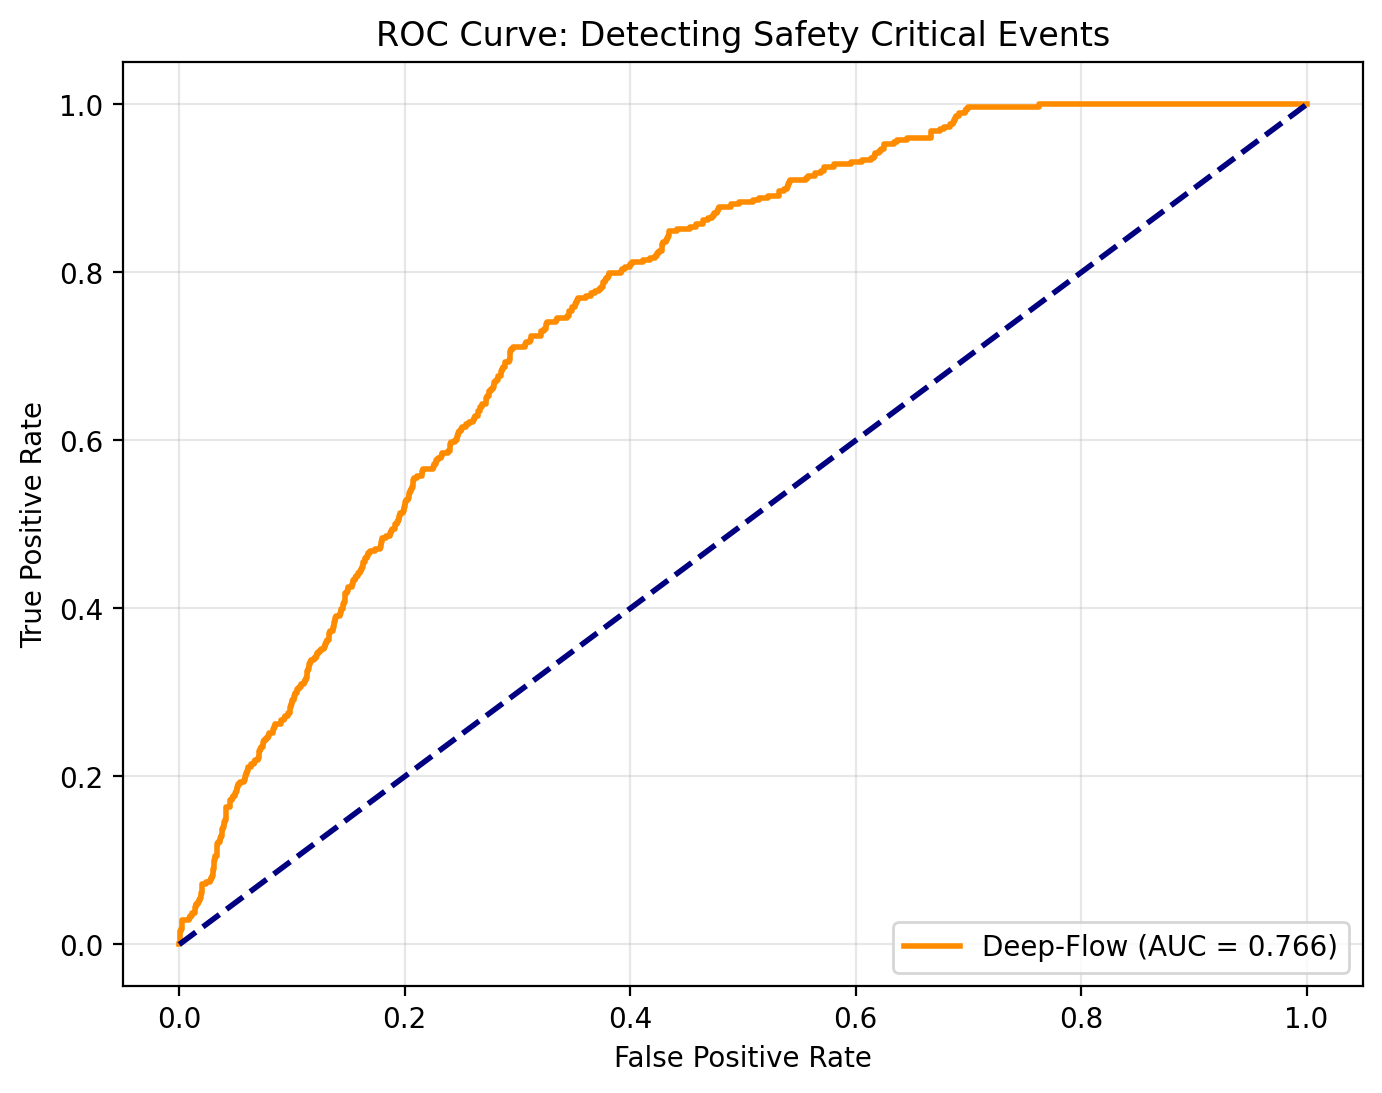

🚀 Final AUC-ROC Score: 0.7662


In [4]:
# We use negative likelihood as the "Anomaly Score"
anomaly_score = -df_scores['log_likelihood']
true_labels = df_scores['is_anomaly']

auc = roc_auc_score(true_labels, anomaly_score)

plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(true_labels, anomaly_score)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Deep-Flow (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Detecting Safety Critical Events')
plt.legend(loc="lower right")

plt.grid(True, alpha=0.3)

# Save the plot as pdf
plt.savefig("../results/roc_curve.pdf", bbox_inches='tight')
plt.show()

print(f"🚀 Final AUC-ROC Score: {auc:.4f}")

## 4. Distribution Analysis
Do the distributions separate? We want the Red curve (Anomalies) to be shifted to the left (Lower Likelihood).


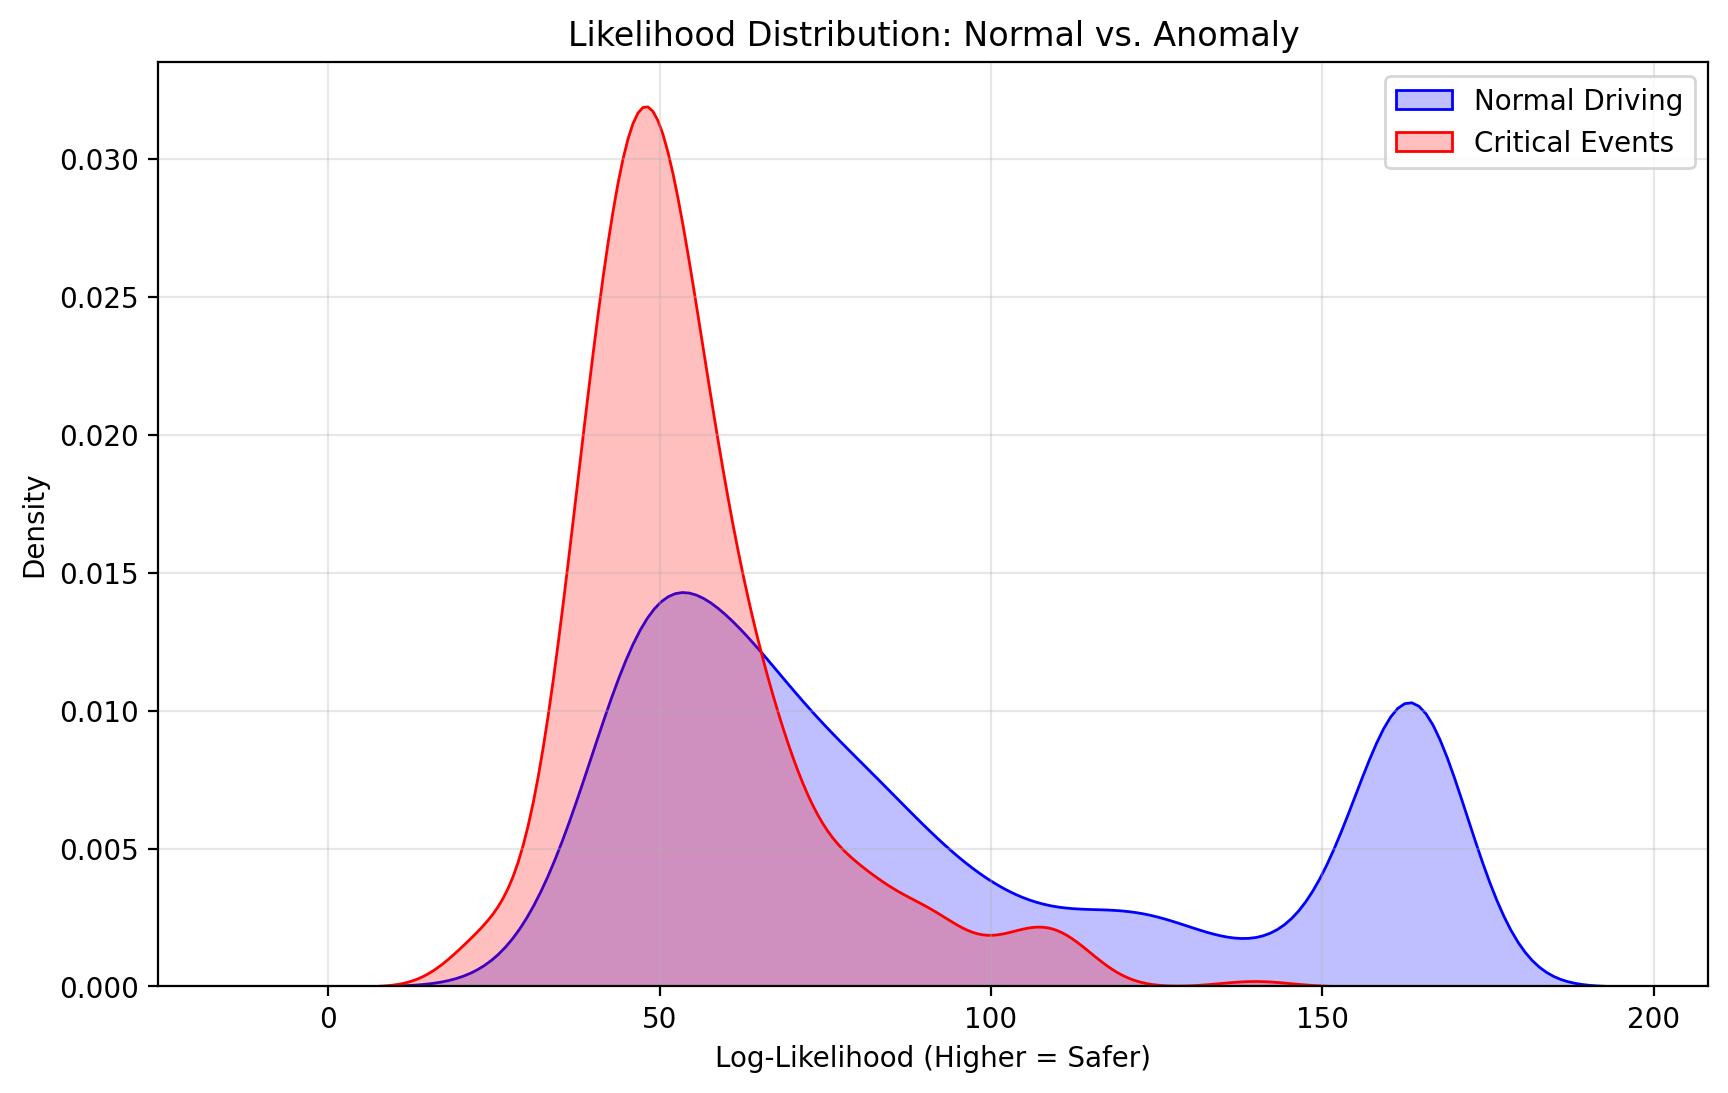

In [7]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_scores[df_scores['is_anomaly']==0], x='log_likelihood', fill=True, color='blue', label='Normal Driving')
sns.kdeplot(data=df_scores[df_scores['is_anomaly']==1], x='log_likelihood', fill=True, color='red', label='Critical Events')
plt.title("Likelihood Distribution: Normal vs. Anomaly")
plt.xlabel("Log-Likelihood (Higher = Safer)")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot as pdf
plt.savefig("../results/likelihood_distribution.pdf", bbox_inches='tight')
plt.show()

## 5. The "Unseen" Anomalies
Let's find scenarios the model thinks are **extremely dangerous** (Low Likelihood) but were NOT in our heuristic golden set.
These are often the "Unknown Unknowns" - rare behaviors we didn't know how to code a rule for.

In [8]:
# Filter for Normal scenarios (according to heuristics) with very Low Likelihood
df_false_positives = df_scores[df_scores['is_anomaly'] == 0].sort_values(by='log_likelihood', ascending=True)

print("Top 5 'Hidden' Anomalies detected by Deep-Flow:")
print(df_false_positives.head(5))

Top 5 'Hidden' Anomalies detected by Deep-Flow:
           scenario_id  log_likelihood  is_anomaly
988   2027293e213bc361        7.048447           0
8376  66699cf0ec4e0fb7       20.442335           0
1388  ef5da6c66f8230f8       20.670670           0
2839  91ed234f60c3501f       20.766186           0
6359  6307508426e85026       23.257423           0


## 6. The Discovery Engine: Analyzing "False Positives"
We look for scenarios where the Heuristic said "Safe" (0) but Deep-Flow said "Danger" (Low Likelihood).
These are the potential "Unknown Unknowns" or superior detections.

In [9]:
# 1. Select Normal Scenarios (according to Heuristic)
df_normal = df_scores[df_scores['is_anomaly'] == 0].copy()

# 2. Sort by Model's Risk Score (Lowest Likelihood = Highest Risk)
df_hidden_dangers = df_normal.sort_values(by='log_likelihood', ascending=True)

# 3. Get Top 5 Candidates
top_candidates = df_hidden_dangers.head(5)

print("🔍 Top 5 'Hidden Anomalies' detected by Deep-Flow:")
print(top_candidates[['scenario_id', 'log_likelihood']])

# %%
print("ids_to_check = [")
for s_id in top_candidates['scenario_id'].values:
    print(f"    '{s_id}',")
print("]")

🔍 Top 5 'Hidden Anomalies' detected by Deep-Flow:
           scenario_id  log_likelihood
988   2027293e213bc361        7.048447
8376  66699cf0ec4e0fb7       20.442335
1388  ef5da6c66f8230f8       20.670670
2839  91ed234f60c3501f       20.766186
6359  6307508426e85026       23.257423
ids_to_check = [
    '2027293e213bc361',
    '66699cf0ec4e0fb7',
    'ef5da6c66f8230f8',
    '91ed234f60c3501f',
    '6307508426e85026',
]
